<a href="https://colab.research.google.com/github/ritwikraha/Open-Generative-Fill/blob/main/experiments/open_gen_fill_text_captioning_with_LM_mask_dilation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup and Imports

In [1]:
!pip install -qq --upgrade diffusers transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 25.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import SamModel, SamProcessor
from transformers import OwlViTProcessor, OwlViTForObjectDetection, Owlv2Processor, Owlv2ForObjectDetection
from diffusers import AutoPipelineForInpainting

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load the image and the text prompt

In [4]:
image_url = "https://i.imgur.com/4ujXoav.jpeg"
raw_image = Image.open(
    requests.get(image_url, stream=True).raw
).convert("RGB")

image = raw_image.resize((512, 512)) # resizing leads to poor captions
edit_prompt = "change the bottle to a firecracker"

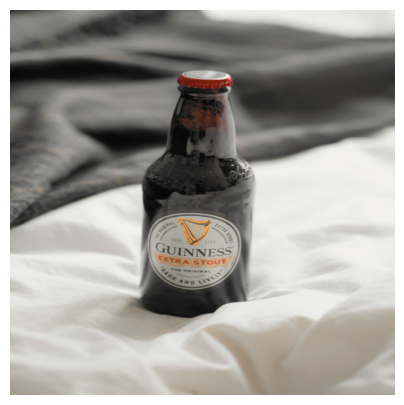

In [5]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.show()

## Extract the objects from the prompt

In [6]:
language_model_id = "Qwen/Qwen1.5-0.5B-Chat"
language_model = AutoModelForCausalLM.from_pretrained(
    language_model_id,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(language_model_id)

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
messages = [
  {"role": "system", "content": "Follow the examples and return the expected output"},
  {"role": "user", "content": "swap mountain and lion"},  # example 1
  {"role": "assistant", "content": "mountain, lion"},  # example 1
  {"role": "user", "content": "change the dog with cat"},  # example 2
  {"role": "assistant", "content": "dog, cat"},  # example 2
  {"role": "user", "content": "change the cat with a dog"},  # example 3
  {"role": "assistant", "content": "cat, dog"},  # example 3
  {"role": "user", "content": "replace the human with a boat"},  # example 4
  {"role": "assistant", "content": "human, boat"},  # example 4
  {"role": "user", "content": "in the above example change the background to the alps"},  # example 5
  {"role": "assistant", "content": "background, alps"},  # example 5
  {"role": "user", "content": "edit the house into a mansion"},  # example 6
  {"role": "assistant", "content": "house, a mansion"},  # example 6
  {"role": "user", "content": edit_prompt}
]
text = tokenizer.apply_chat_template(
  messages,
  tokenize=False,
  add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)

with torch.no_grad():
  generated_ids = language_model.generate(
    model_inputs.input_ids,
    max_new_tokens=512,
    temperature=0.0,
    do_sample=False
  )

  generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.8` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [8]:
response

'bottle, firecracker'

In [9]:
to_replace, replace_with = response.split(", ")

In [10]:
print(f"{to_replace=}")
print(f"{replace_with=}")

to_replace='bottle'
replace_with='firecracker'


## Caption the image

### BLIP Model

In [11]:
caption_model_id = "Salesforce/blip-image-captioning-base"
caption_model = BlipForConditionalGeneration.from_pretrained(caption_model_id).to(device)
caption_processor = BlipProcessor.from_pretrained(caption_model_id)

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
inputs = caption_processor(image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = caption_model.generate(**inputs, max_new_tokens=50)

caption = caption_processor.decode(outputs[0], skip_special_tokens=True)

### LLAVA Model

In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

In [ ]:
max_new_tokens = 50
prompt = "USER: <image>\nWhat is happening in this image?\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 50})

In [ ]:
captioner_output = outputs[0]["generated_text"]

assistant_start = captioner_output.find("ASSISTANT:")

# Extract the substring starting from the index after "ASSISTANT:"
caption = captioner_output[assistant_start + len("ASSISTANT:"):]

### Captioning


In [13]:
caption

'a bottle of beer sitting on a bed'

### Replace caption generator

In [14]:
messages = [
    {"role": "system", "content": "Follow the examples and return the expected output"},
    {"role": "user", "content": "Caption: a bottle of wine in a sunny landscape\nQuery: Swap the bottle with a headphone"},  # example 1
    {"role": "assistant", "content": "a headphone in a sunny landscape"},  # example 1
    {"role": "user", "content": "Caption: a dog playing in the garden\nQuery: Change the dog with cat"},  # example 2
    {"role": "assistant", "content": "a cat playing in the garden"},  # example 2
    {"role": "user", "content": f"Caption: {caption}\nQuery: {edit_prompt}"}
]

text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(device)
with torch.no_grad():
  generated_ids = language_model.generate(
    model_inputs.input_ids,
    max_new_tokens=512,
    temperature=0.0,
    do_sample=False
  )

  generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
  ]

replace_caption = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


In [ ]:
language_model.to("cpu")
del language_model
torch.cuda.empty_cache()

In [ ]:
# uncomment this if not using the qwen to generate caption

# replace_caption = caption.replace(to_replace, replace_with)

In [15]:
print(f"{caption=}")
print(f"{replace_caption=}")

caption='a bottle of beer sitting on a bed'
replace_caption='a firecracker sitting on a bed'


In [ ]:
pipe.to("cpu")
del pipe
torch.cuda.empty_cache()

## Build segmentation mask for inpainting

### OWL V2

In [16]:
owl_v2_model_id = "google/owlv2-base-patch16-ensemble"
processor = Owlv2Processor.from_pretrained(owl_v2_model_id)
od_model = Owlv2ForObjectDetection.from_pretrained(owl_v2_model_id).to(device)
text_queries = [to_replace]
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = od_model(**inputs)
    target_sizes = torch.tensor([image.size]).to(device)
    results = processor.post_process_object_detection(
        outputs, threshold=0.1, target_sizes=target_sizes
    )[0]

boxes = results["boxes"].tolist()

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/620M [00:00<?, ?B/s]

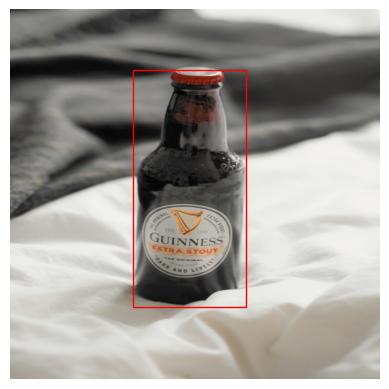

In [17]:
fig, ax = plt.subplots()
ax.imshow(image)

for box in boxes:
    x_min, y_min, x_max, y_max = box
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    )
    ax.add_patch(rect)

plt.axis("off")
plt.show()

In [18]:
od_model.to("cpu")
del od_model
torch.cuda.empty_cache()

### SAM

In [19]:
# SAM for image segmentation
sam_model_id = "facebook/sam-vit-base"
seg_model = SamModel.from_pretrained(sam_model_id).to(device)
processor = SamProcessor.from_pretrained(sam_model_id)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [20]:
input_boxes = [boxes]
inputs = processor(image, input_boxes=input_boxes, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = seg_model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu(),
)[0]

In [21]:
masks = torch.max(masks[:, 0, ...], dim=0, keepdim=False).values
masks.shape

torch.Size([512, 512])

In [22]:
seg_mask = Image.fromarray(masks.numpy())

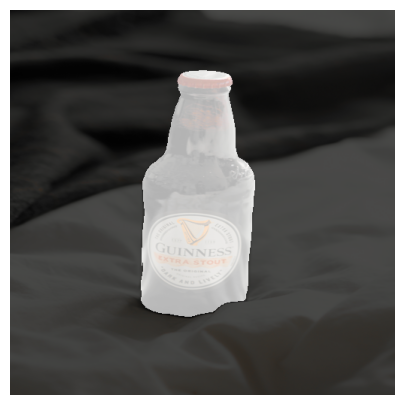

In [23]:
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(seg_mask, alpha=0.7, cmap="gray")
plt.axis("off")
plt.show()

In [24]:
seg_model.to("cpu")
del seg_model
torch.cuda.empty_cache()

## Output Image

### Inpaint the image

In [25]:
pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [33]:
from PIL import ImageFilter

dilation_img = seg_mask.filter(ImageFilter.MaxFilter(3))

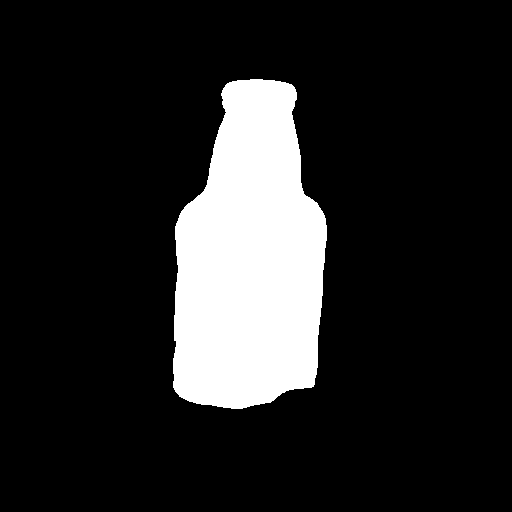

In [28]:
dilation_img

In [31]:
prompt = replace_caption

negative_prompt = """lowres, bad anatomy, bad hands,
text, error, missing fingers, extra digit, fewer digits,
cropped, worst quality, low quality"""

output = pipeline(
    prompt=prompt,
    image=image,
    height=512,
    width=512,
    mask_image=dilation_img,
    negative_prompt=negative_prompt,
    guidance_scale=7.5,
    strength=1
).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

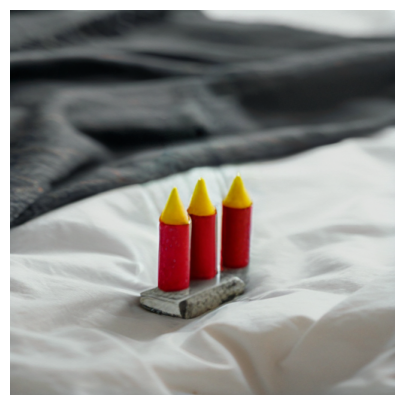

In [32]:
plt.figure(figsize=(5, 5))
plt.imshow(output)
plt.axis("off")
plt.show()

In [ ]:
pipeline.to("cpu")
del pipeline
torch.cuda.empty_cache()